# View train

In [98]:
import glob

imgs = sorted(glob.glob('../data/AOI_2_Vegas_Roads_Train/MUL-PanSharpen_8bit/*.tif'))
preds = sorted(glob.glob('../data/AOI_2_Vegas_Roads_Train/norm_all_masks_ln34_mul_ps_vegetation_aug_dice_predict_train/*.jpg'))
gts = sorted(glob.glob('../data/AOI_2_Vegas_Roads_Train/MUL-PanSharpen_all_mask/*.jpg'))


In [5]:
import numpy as np
from skimage.io import imread,imsave
from skimage import img_as_ubyte,img_as_float
from skimage import exposure
from skimage.draw import circle
import cv2
from collections import Counter
import os
import pandas as pd
from presets import preset_dict


def draw_mask(circle_size,
              line_width,
              ls_list,
              mask_size
             ):

    ls_lines = [(line[len('LINESTRING ('):-1]) for line in ls_list]

    mask = np.zeros((mask_size, mask_size), dtype=np.uint8)
    all_points = []
    
    try:
        for line in ls_lines:
            points = line.split(', ')
            points_xy = []
            for point in points:
                x,y = point.split()
                points_xy.append([x,y])

            all_points.extend(points_xy)

            for i,[x,y] in enumerate(points_xy):
                if i-1>-1:
                    prev_x = int(float(points_xy[i-1][0]))
                    prev_y = int(float(points_xy[i-1][1]))
                    mask = cv2.line(mask,(prev_x,prev_y),(int(float(x)),int(float(y))),(150),line_width)

            all_points_text = [(point[0]+' '+point[1]) for point in all_points]
            count_dict =  Counter(all_points_text)
            for key, value in count_dict.items():
                if(value>1):
                    x,y = key.split()
                    # rr, cc = circle(int(float(y)), int(float(x)), circle_size)
                    # mask[rr.clip(min=0,max=mask_size-1), cc.clip(min=0,max=mask_size-1)] = 255
        return mask
    except:
        return mask


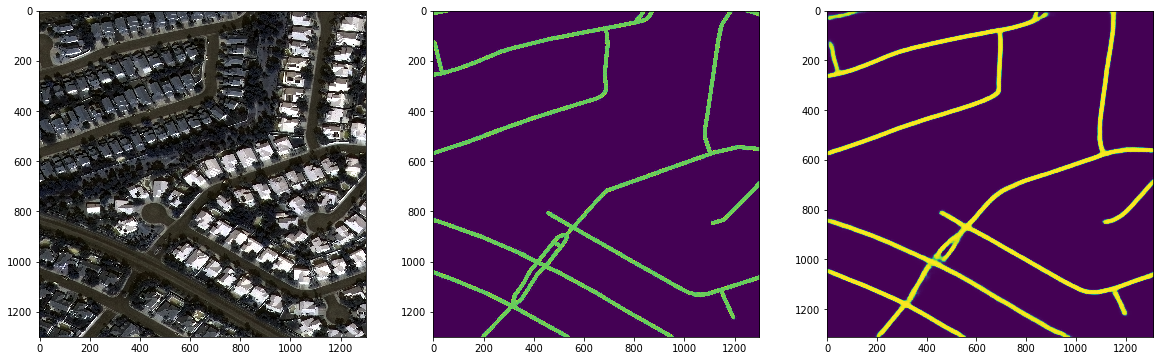

In [117]:
from skimage.io import imread
import random
import matplotlib.pyplot as plt

index = random.randint(0,len(imgs))

img = imread(imgs[index])
pred = imread(preds[index])
gt = imread(gts[index])


fig=plt.figure(figsize=(20, 6))

fig.add_subplot(1, 3, 1)
plt.imshow(img[:,:,0:3])

fig.add_subplot(1, 3, 2)
plt.imshow(gt)

fig.add_subplot(1, 3, 3)
plt.imshow(pred)

plt.show()     

# View test

In [1]:
import pandas as pd

submit_df = pd.read_csv('../solutions/norm_test_all_masks_8channel.csv')
submit_df = submit_df.groupby(by=['ImageId'])['WKT_Pix'].apply(list)
submit_df = submit_df.reset_index()

In [360]:
mask_ls.sum()

1666350

In [6]:
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
from skimage.io import imread
import rasterio
from tqdm import tqdm
import skimage.transform
import math
from skimage.morphology import skeletonize
import sknw
import cv2
from collections import Counter
from skimage.draw import circle
%matplotlib inline

def simplify_edge(ps: np.ndarray, max_distance=3):
    """
    Combine multiple points of graph edges to line segments
    so distance from points to segments <= max_distance
    :param ps: array of points in the edge, including node coordinates
    :param max_distance: maximum distance, if exceeded new segment started
    :return: ndarray of new nodes coordinates
    """
    res_points = []
    cur_idx = 0
    # combine points to the single line while distance from the line to any point < max_distance
    for i in range(1, len(ps) - 1):
        segment = ps[cur_idx:i + 1, :] - ps[cur_idx, :]
        angle = -math.atan2(segment[-1, 1], segment[-1, 0])
        ca = math.cos(angle)
        sa = math.sin(angle)
        # rotate all the points so line is alongside first column coordinate
        # and the second col coordinate means the distance to the line
        segment_rotated = np.array([[ca, -sa], [sa, ca]]).dot(segment.T)
        distance = np.max(np.abs(segment_rotated[1, :]))
        if distance > max_distance:
            res_points.append(ps[cur_idx, :])
            cur_idx = i
    if len(res_points) == 0:
        res_points.append(ps[0, :])
    res_points.append(ps[-1, :])

    return np.array(res_points)

def process_masks(mask_paths, thresh = 0.3):
    lnstr_df = pd.DataFrame()
    with tqdm(total=len(mask_paths)) as pbar:
        for msk_pth in mask_paths:
            #print(msk_pth)
            msk = imread(msk_pth)
            msk = msk[6:1306, 6:1306]
            msk_nme = msk_pth.split('/')[3]
            img_id = msk_nme[msk_nme.find('AOI'):msk_nme.find('.')]

            # open and skeletonize
            img_clip = np.zeros_like(msk)
            img_clip[msk > 255 * thresh] = 1
            
            ske = skeletonize(img_clip).astype(np.uint16)

            # build graph from skeleton
            graph = sknw.build_sknw(ske, multi=True)
            segments = simplify_graph(graph)

            linestrings = segmets_to_linestrings(segments)
            local = pd.DataFrame()
            local['WKT_Pix'] = linestrings
            local['ImageId'] = img_id

            lnstr_df = pd.concat([lnstr_df, local], ignore_index = True)
            pbar.update(1)
    return lnstr_df

def simplify_graph(graph, max_distance=2):
    """
    :type graph: MultiGraph
    """
    all_segments = []
    for (s, e) in graph.edges():
        for _, val in graph[s][e].items():
            ps = val['pts']
            full_segments = np.row_stack([
                graph.node[s]['o'],
                ps,
                graph.node[e]['o']
            ])

            segments = simplify_edge(full_segments, max_distance=max_distance)
            all_segments.append(segments)

    return all_segments

def segment_to_linestring(segment):
    
    if len(segment) < 2:
        return []
    
    linestring = 'LINESTRING ({})'
    sublinestring = ''
        
    for i, node in enumerate(segment):
        
        if i == 0:
            sublinestring = sublinestring + '{:.1f} {:.1f}'.format(node[1], node[0])
        else:
            if node[0] == segment[i - 1][0] and node[1] == segment[i - 1][1]:
                if len(segment) == 2:
                    return []
                continue
            if i > 1 and node[0] == segment[i - 2][0] and node[1] == segment[i - 2][1]:
                continue
            sublinestring = sublinestring + ', {:.1f} {:.1f}'.format(node[1], node[0])
    linestring = linestring.format(sublinestring)
    return linestring

def segmets_to_linestrings(segments):
    linestrings = []
    for segment in segments:
        linestring = segment_to_linestring(segment)
        if len(linestring) > 0:
            linestrings.append(linestring)
    if len(linestrings) == 0:
        linestrings = ['LINESTRING EMPTY']
    return linestrings

In [41]:
import glob

imgs = sorted(glob.glob('../data/AOI_5_Khartoum_Roads_Test_Public/MUL-PanSharpen_8bit/*.tif'))
preds = sorted(glob.glob('../data/AOI_5_Khartoum_Roads_Test_Public/16_bit_norm_all_masks_ln34_mul_ps_8channel_aug_dice_predict/*.jpg'))
# gts = sorted(glob.glob('../data/AOI_2_Vegas_Roads_Test_Public/MUL-PanSharpen_all_mask/*.jpg'))


100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


../data/AOI_5_Khartoum_Roads_Test_Public/MUL-PanSharpen_8bit/MUL-PanSharpen_AOI_5_Khartoum_img52.tif


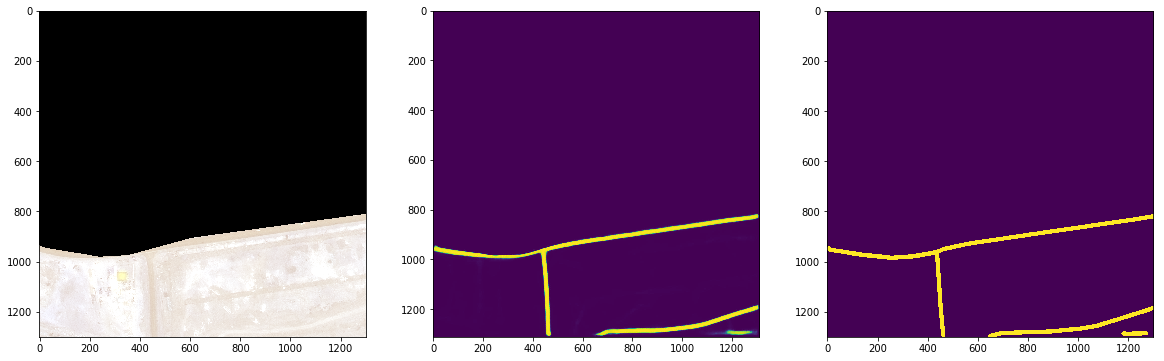

In [53]:
from skimage.io import imread
import random
import matplotlib.pyplot as plt

index = random.randint(0,len(imgs))
# print (index)

# sample = submit_df[submit_df.ImageId == imgs[index].split('/')[-1].split('MUL-PanSharpen_')[-1].split('.tif')[0]]
sample = process_masks([preds[index]], thresh = 0.7)
sample = sample.groupby(by=['ImageId'])['WKT_Pix'].apply(list).values[0]

img = imread(imgs[index])
pred = imread(preds[index])

print(imgs[index])

mask_ls = draw_mask(circle_size=0,
              line_width=15,
              ls_list=sample,
              mask_size=1300
             )

fig=plt.figure(figsize=(20, 6))

fig.add_subplot(1, 3, 1)
plt.imshow(img[:,:,0:3])

fig.add_subplot(1, 3, 2)
plt.imshow(pred)

fig.add_subplot(1, 3, 3)
plt.imshow(mask_ls)

plt.show()     

../data/AOI_2_Vegas_Roads_Test_Public/MUL-PanSharpen_8bit/MUL-PanSharpen_AOI_2_Vegas_img996.tif


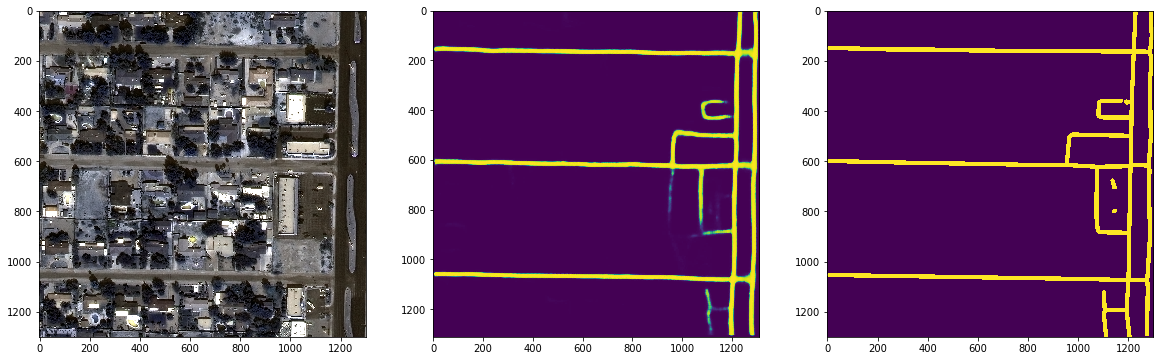

In [30]:
from skimage.io import imread
import random
import matplotlib.pyplot as plt

index = random.randint(0,len(imgs))
sample = submit_df[submit_df.ImageId == imgs[index].split('/')[-1].split('MUL-PanSharpen_')[-1].split('.tif')[0]]

img = imread(imgs[index])
pred = imread(preds[index])

print(imgs[index])

mask_ls = draw_mask(circle_size=0,
              line_width=15,
              ls_list=sample.WKT_Pix.values[0],
              mask_size=1300
             )

fig=plt.figure(figsize=(20, 6))

fig.add_subplot(1, 3, 1)
plt.imshow(img[:,:,0:3])

fig.add_subplot(1, 3, 2)
plt.imshow(pred)

fig.add_subplot(1, 3, 3)
plt.imshow(mask_ls)

plt.show()     

# Shit

In [3]:
!ls -ls ../data/AOI_2_Vegas_Roads_Train/MUL-PanSharpen_8bit/ | wc -l

990


In [5]:
len(imgs),len(preds),len(gts)

(989, 989, 989)

In [24]:
import glob

g = glob.glob('../data/AOI_2_Vegas_Roads_Train/MUL-PanSharpen_8bit/*.tif')
ids1 = [(path.split('_img')[1].split('.ti')[0]) for path in g]
g = glob.glob('../data/AOI_2_Vegas_Roads_Train/MUL-PanSharpen_mask/*.jpg')
ids2 = [(path.split('_img')[1].split('.jp')[0]) for path in g]
print(set(ids1) - set(ids2))

g = glob.glob('../data/AOI_3_Paris_Roads_Train/MUL-PanSharpen_8bit/*.tif')
ids1 = [(path.split('_img')[1].split('.ti')[0]) for path in g]
g = glob.glob('../data/AOI_3_Paris_Roads_Train/MUL-PanSharpen_mask/*.jpg')
ids2 = [(path.split('_img')[1].split('.jp')[0]) for path in g]
print(set(ids1) - set(ids2))

g = glob.glob('../data/AOI_4_Shanghai_Roads_Train/MUL-PanSharpen_8bit/*.tif')
ids1 = [(path.split('_img')[1].split('.ti')[0]) for path in g]
g = glob.glob('../data/AOI_4_Shanghai_Roads_Train/MUL-PanSharpen_mask/*.jpg')
ids2 = [(path.split('_img')[1].split('.jp')[0]) for path in g]
print(set(ids1) - set(ids2))

g = glob.glob('../data/AOI_5_Khartoum_Roads_Train/MUL-PanSharpen_8bit/*.tif')
ids1 = [(path.split('_img')[1].split('.ti')[0]) for path in g]
g = glob.glob('../data/AOI_5_Khartoum_Roads_Train/MUL-PanSharpen_mask/*.jpg')
ids2 = [(path.split('_img')[1].split('.jp')[0]) for path in g]
print(set(ids1) - set(ids2))



{'200', '286', '234', '1534', '1488', '1159', '1448', '42'}
{'162', '286', '238', '127', '402', '166', '106', '263', '213', '309', '139', '234', '425', '140', '467', '105', '323', '77', '499', '233', '97', '110', '475', '377', '104', '278', '258', '392', '122', '505', '324', '185', '138', '239', '354', '119', '187', '121', '484', '491', '215', '321', '398', '189', '7', '512', '462', '424', '400', '486', '509', '125', '371'}
{'1683', '1032', '1827', '1130', '1956', '1180', '272', '1083', '234', '502', '164', '277', '1369', '1386', '1242', '1572', '620', '275', '1766', '1371', '578', '576', '431', '201', '198', '388', '1994', '933', '1910', '1871', '501', '1985', '1992', '1989', '1460', '203', '1725', '612', '619', '310', '580', '1955', '541', '235', '315', '1701', '656', '314', '1641', '710', '1983', '1525', '468', '1981', '1417', '237', '194', '1993', '1849', '499', '389', '1227', '543', '1913', '390', '1570', '1527', '1990', '1890', '719', '197', '428', '1914', '242', '1320', '1970', 

{'1159', '1448', '1488', '1534', '200', '234', '286', '42'}

In [13]:
ids2

[]

In [4]:
!ls -ls ../data/AOI_5_Khartoum_Roads_Test_Public///RGB-PanSharpen_8bit/ | wc -l

96


In [1]:
!ls ../data/AOI_2_Vegas_Roads_Test_Public/ln34_mul_ps_8channel_aug_dice_predict_pad/MUL-PanSharpen_AOI_2_Vegas_img1005.jpg

../data/AOI_2_Vegas_Roads_Test_Public/ln34_mul_ps_8channel_aug_dice_predict_pad/MUL-PanSharpen_AOI_2_Vegas_img1005.jpg


In [2]:
from skimage.io import imread

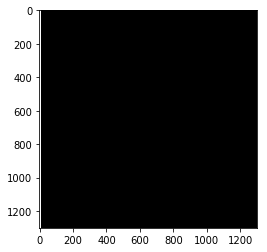

In [21]:
or_img = imread('../data/AOI_2_Vegas_Roads_Test_Public/RGB-PanSharpen_8bit/RGB-PanSharpen_AOI_2_Vegas_img1611.tif')
plt.imshow(or_img)

In [3]:
img = imread('../data/AOI_2_Vegas_Roads_Test_Public/ln34_mul_ps_8channel_aug_dice_predict_pad/MUL-PanSharpen_AOI_2_Vegas_img1005.jpg')

In [13]:
img = imread('../data/AOI_2_Vegas_Roads_Test_Public/ln34_wide_masks_mul_ps_8channel_aug_dice_predict_pad/MUL-PanSharpen_AOI_2_Vegas_img1005.jpg')

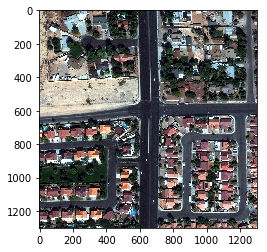

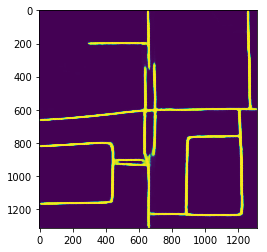

In [12]:
import matplotlib.pyplot as plt

plt.imshow(img)

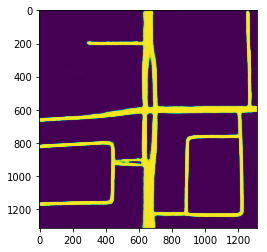

In [14]:
import matplotlib.pyplot as plt

plt.imshow(img)

In [18]:
img.shape

(1312, 1312)

In [16]:
import pandas as pd

df = pd.DataFrame()
df['img'] = img.reshape(-1)


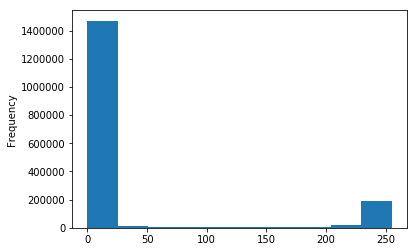

In [17]:
%matplotlib inline

df['img'].plot(kind='hist')

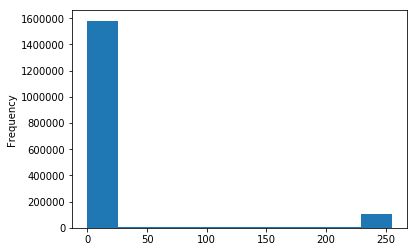

In [10]:
%matplotlib inline

df['img'].plot(kind='hist')

In [5]:
!du -h ../data/AOI_2_Vegas_Roads_Test_Public/ln34_mul_ps_urban_aug_dice_predict_train_for_single_city/

du: cannot access '../data/AOI_2_Vegas_Roads_Test_Public/ln34_mul_ps_urban_aug_dice_predict_train_for_single_city/*': No such file or directory


In [13]:
!ls ../data/AOI_3_Paris_Roads_Train/paris_ln34_mul_ps_urban_aug_dice_predict_train/*85*

../data/AOI_3_Paris_Roads_Train/paris_ln34_mul_ps_urban_aug_dice_predict_train/MUL-PanSharpen_AOI_3_Paris_img285.jpg
../data/AOI_3_Paris_Roads_Train/paris_ln34_mul_ps_urban_aug_dice_predict_train/MUL-PanSharpen_AOI_3_Paris_img485.jpg
../data/AOI_3_Paris_Roads_Train/paris_ln34_mul_ps_urban_aug_dice_predict_train/MUL-PanSharpen_AOI_3_Paris_img85.jpg


In [12]:
!ls ../data/AOI_3_Paris_Roads_Train/ln34_mul_ps_vegetation_aug_dice_predict_train/*85*

../data/AOI_3_Paris_Roads_Train/ln34_mul_ps_vegetation_aug_dice_predict_train/MUL-PanSharpen_AOI_3_Paris_img285.jpg
../data/AOI_3_Paris_Roads_Train/ln34_mul_ps_vegetation_aug_dice_predict_train/MUL-PanSharpen_AOI_3_Paris_img485.jpg
../data/AOI_3_Paris_Roads_Train/ln34_mul_ps_vegetation_aug_dice_predict_train/MUL-PanSharpen_AOI_3_Paris_img85.jpg


In [6]:
!du -h ../data/AOI_2_Vegas_Roads_Test_Public/ln34_mul_ps_urban_aug_dice_predict_for_single_city/ 
!du -h ../data/AOI_3_Paris_Roads_Test_Public/ln34_mul_ps_urban_aug_dice_predict_for_single_city/ 
!du -h ../data/AOI_4_Shanghai_Roads_Test_Public/ln34_mul_ps_urban_aug_dice_predict_for_single_city/ 
!du -h ../data/AOI_5_Khartoum_Roads_Test_Public/ln34_mul_ps_urban_aug_dice_predict_for_single_city/

!du -h ../data/AOI_2_Vegas_Roads_Train/ln34_mul_ps_urban_aug_dice_predict_train_for_single_city/
!du -h ../data/AOI_3_Paris_Roads_Train/ln34_mul_ps_urban_aug_dice_predict_train_for_single_city/ 
!du -h ../data/AOI_4_Shanghai_Roads_Train/ln34_mul_ps_urban_aug_dice_predict_train_for_single_city/ 
!du -h ../data/AOI_5_Khartoum_Roads_Train/ln34_mul_ps_urban_aug_dice_predict_train_for_single_city/

19M	../data/AOI_2_Vegas_Roads_Test_Public/ln34_mul_ps_urban_aug_dice_predict_for_single_city/
2.5M	../data/AOI_3_Paris_Roads_Test_Public/ln34_mul_ps_urban_aug_dice_predict_for_single_city/
22M	../data/AOI_4_Shanghai_Roads_Test_Public/ln34_mul_ps_urban_aug_dice_predict_for_single_city/
5.5M	../data/AOI_5_Khartoum_Roads_Test_Public/ln34_mul_ps_urban_aug_dice_predict_for_single_city/
59M	../data/AOI_2_Vegas_Roads_Train/ln34_mul_ps_urban_aug_dice_predict_train_for_single_city/
6.1M	../data/AOI_3_Paris_Roads_Train/ln34_mul_ps_urban_aug_dice_predict_train_for_single_city/
67M	../data/AOI_4_Shanghai_Roads_Train/ln34_mul_ps_urban_aug_dice_predict_train_for_single_city/
19M	../data/AOI_5_Khartoum_Roads_Train/ln34_mul_ps_urban_aug_dice_predict_train_for_single_city/


In [1]:
!ls -ls ../data/AOI_2_Vegas_Roads_Test_Public/vegas_ln34_mul_ps_urban_aug_dice_predict/ | wc -l
!ls -ls ../data/AOI_3_Paris_Roads_Test_Public/paris_ln34_mul_ps_urban_aug_dice_predict/ | wc -l
!ls -ls ../data/AOI_4_Shanghai_Roads_Test_Public/shanghai_ln34_mul_ps_urban_aug_dice_predict/ | wc -l
!ls -ls ../data/AOI_5_Khartoum_Roads_Test_Public/khartoum_ln34_mul_ps_urban_aug_dice_predict// | wc -l

!ls -ls ../data/AOI_2_Vegas_Roads_Train/vegas_ln34_mul_ps_urban_aug_dice_predict/ | wc -l
!ls -ls ../data/AOI_3_Paris_Roads_Train/paris_ln34_mul_ps_urban_aug_dice_predict_train/ | wc -l
!ls -ls ../data/AOI_4_Shanghai_Roads_Train/shanghai_ln34_mul_ps_urban_aug_dice_predict_train/ | wc -l
!ls -ls ../data/AOI_5_Khartoum_Roads_Train/khartoum_ln34_mul_ps_urban_aug_dice_predict_train/ | wc -l

331
105
400
96
982
258
1029
284


# Play with 16 bit images

In [1]:
import glob

g = glob.glob('../data/AOI_2_Vegas_Roads_Train/MUL-PanSharpen/*.tif')

In [17]:
from skimage.io import imread

img = imread(g[0])

In [19]:
from skimage.transform import rotate

img = rotate(image=img, angle = 45, preserve_range = True)

In [20]:
img.max()

1991.2674932342427

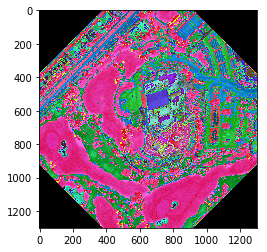

In [21]:
import matplotlib.pyplot as plt

plt.imshow(img[:,:,0:3].astype('uint8'))
plt.show()

# Compare folds

In [40]:
import numpy as np
from skimage.io import imread,imsave
from skimage import img_as_ubyte,img_as_float
from skimage import exposure
from skimage.draw import circle
import cv2
from collections import Counter
import os
import pandas as pd
from presets import preset_dict


def draw_mask(circle_size,
              line_width,
              ls_list,
              mask_size,
              vflip=False,
              hflip=False
             ):

    ls_lines = [(line[len('LINESTRING ('):-1]) for line in ls_list]

    mask = np.zeros((mask_size, mask_size), dtype=np.uint8)
    all_points = []
    
    try:
        for line in ls_lines:
            points = line.split(', ')
            points_xy = []
            for point in points:
                x,y = point.split()
                points_xy.append([x,y])

            all_points.extend(points_xy)

            for i,[x,y] in enumerate(points_xy):
                if i-1>-1:
                    prev_x = int(float(points_xy[i-1][0]))
                    prev_y = int(float(points_xy[i-1][1]))
                    mask = cv2.line(mask,(prev_x,prev_y),(int(float(x)),int(float(y))),(150),line_width)

            all_points_text = [(point[0]+' '+point[1]) for point in all_points]
            count_dict =  Counter(all_points_text)
            for key, value in count_dict.items():
                if(value>1):
                    x,y = key.split()
                    # rr, cc = circle(int(float(y)), int(float(x)), circle_size)
                    # mask[rr.clip(min=0,max=mask_size-1), cc.clip(min=0,max=mask_size-1)] = 255
        print(vflip,hflip)
        if vflip == True:
            return np.flipud (mask)
        if hflip == True:
            return np.fliplr(mask)        
        else:
            return mask
    except:
        return mask


In [36]:
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
from skimage.io import imread
import rasterio
from tqdm import tqdm
import skimage.transform
import math
from skimage.morphology import skeletonize
import sknw
import cv2
from collections import Counter
from skimage.draw import circle
%matplotlib inline

def simplify_edge(ps: np.ndarray, max_distance=3):
    """
    Combine multiple points of graph edges to line segments
    so distance from points to segments <= max_distance
    :param ps: array of points in the edge, including node coordinates
    :param max_distance: maximum distance, if exceeded new segment started
    :return: ndarray of new nodes coordinates
    """
    res_points = []
    cur_idx = 0
    # combine points to the single line while distance from the line to any point < max_distance
    for i in range(1, len(ps) - 1):
        segment = ps[cur_idx:i + 1, :] - ps[cur_idx, :]
        angle = -math.atan2(segment[-1, 1], segment[-1, 0])
        ca = math.cos(angle)
        sa = math.sin(angle)
        # rotate all the points so line is alongside first column coordinate
        # and the second col coordinate means the distance to the line
        segment_rotated = np.array([[ca, -sa], [sa, ca]]).dot(segment.T)
        distance = np.max(np.abs(segment_rotated[1, :]))
        if distance > max_distance:
            res_points.append(ps[cur_idx, :])
            cur_idx = i
    if len(res_points) == 0:
        res_points.append(ps[0, :])
    res_points.append(ps[-1, :])

    return np.array(res_points)

def process_masks(mask_paths, thresh = 0.3):
    lnstr_df = pd.DataFrame()
    with tqdm(total=len(mask_paths)) as pbar:
        for msk_pth in mask_paths:
            #print(msk_pth)
            msk = imread(msk_pth)
            msk = msk[6:1306, 6:1306]
            msk_nme = msk_pth.split('/')[3]
            img_id = msk_nme[msk_nme.find('AOI'):msk_nme.find('.')]

            # open and skeletonize
            img_clip = np.zeros_like(msk)
            img_clip[msk > 255 * thresh] = 1
            
            ske = skeletonize(img_clip).astype(np.uint16)

            # build graph from skeleton
            graph = sknw.build_sknw(ske, multi=True)
            segments = simplify_graph(graph)

            linestrings = segmets_to_linestrings(segments)
            local = pd.DataFrame()
            local['WKT_Pix'] = linestrings
            local['ImageId'] = img_id

            lnstr_df = pd.concat([lnstr_df, local], ignore_index = True)
            pbar.update(1)
    return lnstr_df

def simplify_graph(graph, max_distance=2):
    """
    :type graph: MultiGraph
    """
    all_segments = []
    for (s, e) in graph.edges():
        for _, val in graph[s][e].items():
            ps = val['pts']
            full_segments = np.row_stack([
                graph.node[s]['o'],
                ps,
                graph.node[e]['o']
            ])

            segments = simplify_edge(full_segments, max_distance=max_distance)
            all_segments.append(segments)

    return all_segments

def segment_to_linestring(segment):
    
    if len(segment) < 2:
        return []
    
    linestring = 'LINESTRING ({})'
    sublinestring = ''
        
    for i, node in enumerate(segment):
        
        if i == 0:
            sublinestring = sublinestring + '{:.1f} {:.1f}'.format(node[1], node[0])
        else:
            if node[0] == segment[i - 1][0] and node[1] == segment[i - 1][1]:
                if len(segment) == 2:
                    return []
                continue
            if i > 1 and node[0] == segment[i - 2][0] and node[1] == segment[i - 2][1]:
                continue
            sublinestring = sublinestring + ', {:.1f} {:.1f}'.format(node[1], node[0])
    linestring = linestring.format(sublinestring)
    return linestring

def segmets_to_linestrings(segments):
    linestrings = []
    for segment in segments:
        linestring = segment_to_linestring(segment)
        if len(linestring) > 0:
            linestrings.append(linestring)
    if len(linestrings) == 0:
        linestrings = ['LINESTRING EMPTY']
    return linestrings

In [47]:
import glob

cty = 'AOI_3_Paris_Roads_Test_Public'

imgs = sorted(glob.glob('../data/'+cty+'/MUL-PanSharpen_8bit/*.tif'))
fold1 = sorted(glob.glob('../data/'+cty+'/norm_all_masks_ln34_mul_ps_8channel_aug_dice_predict_train_fold0_hflip0_vflip0/*.jpg'))
fold2 = sorted(glob.glob('../data/'+cty+'/norm_all_masks_ln34_mul_ps_8channel_aug_dice_predict_train_fold1_hflip0_vflip0//*.jpg'))
fold3 = sorted(glob.glob('../data/'+cty+'/norm_all_masks_ln34_mul_ps_8channel_aug_dice_predict_train_fold2_hflip0_vflip0/*.jpg'))

fold1_h = sorted(glob.glob('../data/'+cty+'/norm_all_masks_ln34_mul_ps_8channel_aug_dice_predict_train_fold0_hflip1_vflip0/*.jpg'))
fold2_h = sorted(glob.glob('../data/'+cty+'/norm_all_masks_ln34_mul_ps_8channel_aug_dice_predict_train_fold0_hflip1_vflip0//*.jpg'))
fold3_h = sorted(glob.glob('../data/'+cty+'/norm_all_masks_ln34_mul_ps_8channel_aug_dice_predict_train_fold0_hflip1_vflip0/*.jpg'))

fold1_v = sorted(glob.glob('../data/'+cty+'/norm_all_masks_ln34_mul_ps_8channel_aug_dice_predict_train_fold0_hflip0_vflip1/*.jpg'))
fold2_v = sorted(glob.glob('../data/'+cty+'/norm_all_masks_ln34_mul_ps_8channel_aug_dice_predict_train_fold0_hflip0_vflip1/*.jpg'))
fold3_v = sorted(glob.glob('../data/'+cty+'/norm_all_masks_ln34_mul_ps_8channel_aug_dice_predict_train_fold0_hflip0_vflip1/*.jpg'))

# gts = sorted(glob.glob('../data/AOI_2_Vegas_Roads_Test_Public/MUL-PanSharpen_all_mask/*.jpg'))


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


../data/AOI_3_Paris_Roads_Test_Public/MUL-PanSharpen_8bit/MUL-PanSharpen_AOI_3_Paris_img240.tif
False False
False False
False False
False True
False True
False True
True False
True False
True False


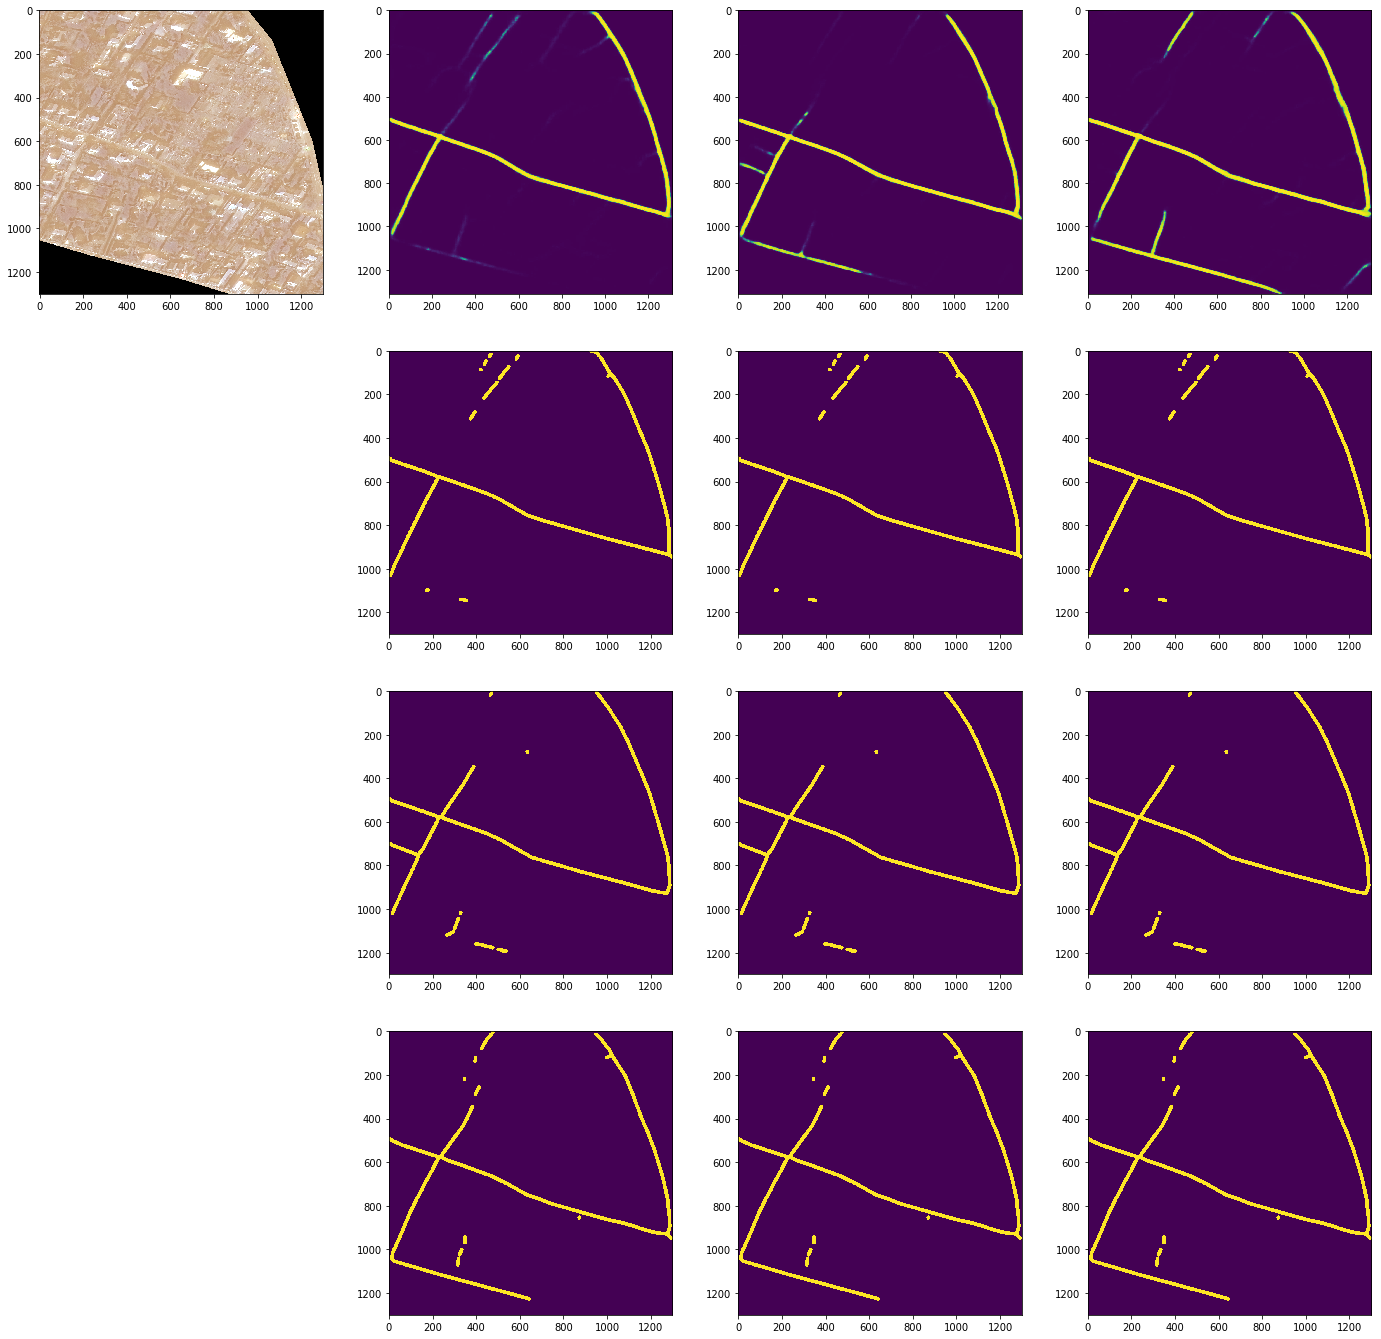

In [51]:
from skimage.io import imread
import random
import matplotlib.pyplot as plt

index = random.randint(0,len(imgs))
# print (index)

# sample = submit_df[submit_df.ImageId == imgs[index].split('/')[-1].split('MUL-PanSharpen_')[-1].split('.tif')[0]]
sample1 = process_masks([fold1[index]], thresh = 0.3)
sample1 = sample1.groupby(by=['ImageId'])['WKT_Pix'].apply(list).values[0]

sample2 = process_masks([fold1[index]], thresh = 0.3)
sample2 = sample2.groupby(by=['ImageId'])['WKT_Pix'].apply(list).values[0]

sample3 = process_masks([fold1[index]], thresh = 0.3)
sample3 = sample3.groupby(by=['ImageId'])['WKT_Pix'].apply(list).values[0]

sample1_h = process_masks([fold1_h[index]], thresh = 0.3)
sample1_h = sample1_h.groupby(by=['ImageId'])['WKT_Pix'].apply(list).values[0]

sample2_h = process_masks([fold1_h[index]], thresh = 0.3)
sample2_h = sample2_h.groupby(by=['ImageId'])['WKT_Pix'].apply(list).values[0]

sample3_h = process_masks([fold1_h[index]], thresh = 0.3)
sample3_h = sample3_h.groupby(by=['ImageId'])['WKT_Pix'].apply(list).values[0]


sample1_v = process_masks([fold1_v[index]], thresh = 0.3)
sample1_v = sample1_v.groupby(by=['ImageId'])['WKT_Pix'].apply(list).values[0]

sample2_v = process_masks([fold1_v[index]], thresh = 0.3)
sample2_v = sample2_v.groupby(by=['ImageId'])['WKT_Pix'].apply(list).values[0]

sample3_v = process_masks([fold1_v[index]], thresh = 0.3)
sample3_v = sample3_v.groupby(by=['ImageId'])['WKT_Pix'].apply(list).values[0]


img = imread(imgs[index])
pred1 = imread(fold1[index])
pred2 = imread(fold2[index])
pred3 = imread(fold3[index])

print(imgs[index])

mask_ls1 = draw_mask(circle_size=0,
              line_width=15,
              ls_list=sample1,
              mask_size=1300
             )

mask_ls2 = draw_mask(circle_size=0,
              line_width=15,
              ls_list=sample2,
              mask_size=1300
             )

mask_ls3 = draw_mask(circle_size=0,
              line_width=15,
              ls_list=sample3,
              mask_size=1300
             )


mask_ls1_h = draw_mask(circle_size=0,
              line_width=15,
              ls_list=sample1_h,
              mask_size=1300,
              hflip=True
             )

mask_ls2_h = draw_mask(circle_size=0,
              line_width=15,
              ls_list=sample2_h,
              mask_size=1300,
              hflip=True
                       
             )

mask_ls3_h = draw_mask(circle_size=0,
              line_width=15,
              ls_list=sample3_h,
              mask_size=1300,
              hflip=True
             )


mask_ls1_v = draw_mask(circle_size=0,
              line_width=15,
              ls_list=sample1_v,
              mask_size=1300,
              vflip=True
             )

mask_ls2_v = draw_mask(circle_size=0,
              line_width=15,
              ls_list=sample2_v,
              mask_size=1300,
              vflip=True
             )

mask_ls3_v = draw_mask(circle_size=0,
              line_width=15,
              ls_list=sample3_v,
              mask_size=1300,
              vflip=True
             )

fig=plt.figure(figsize=(24, 24))

fig.add_subplot(4, 4, 1)
plt.imshow(img[:,:,0:3])

fig.add_subplot(4, 4, 2)
plt.imshow(pred1)
fig.add_subplot(4, 4, 3)
plt.imshow(pred2)
fig.add_subplot(4, 4, 4)
plt.imshow(pred3)

fig.add_subplot(4, 4, 6)
plt.imshow(mask_ls1)
fig.add_subplot(4, 4, 7)
plt.imshow(mask_ls2)
fig.add_subplot(4, 4, 8)
plt.imshow(mask_ls3)

fig.add_subplot(4, 4, 10)
plt.imshow(mask_ls1_h)
fig.add_subplot(4, 4, 11)
plt.imshow(mask_ls2_h)
fig.add_subplot(4, 4, 12)
plt.imshow(mask_ls3_h)

fig.add_subplot(4, 4, 14)
plt.imshow(mask_ls1_v)
fig.add_subplot(4, 4, 15)
plt.imshow(mask_ls2_v)
fig.add_subplot(4, 4, 16)
plt.imshow(mask_ls3_v)

plt.show()     

# Readme.md